# Download and Prep Data

In [3]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import math
from operator import itemgetter

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

from sklearn import tree
from sklearn.tree import _tree

from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import RandomForestClassifier 

from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import GradientBoostingClassifier 

from sklearn.model_selection import GridSearchCV     
from sklearn.model_selection import cross_val_score 

from sklearn.linear_model  import LinearRegression
from sklearn.linear_model  import LogisticRegression
from sklearn.metrics import confusion_matrix , classification_report

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import warnings
warnings.filterwarnings("ignore")


sns.set()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

INFILE = "C:\\Users\\richd\\data\\HMEQ_Loss.csv"

TARGET_F = "TARGET_BAD_FLAG"                         # whether or not the Home Equity Loan defaulted
TARGET_A = "TARGET_LOSS_AMT"                         # amount of money lost for loans that went bad

df = pd.read_csv(INFILE)

dt = df.dtypes

objList = []
numList = []

for i in dt.index :
    if i in ( [ TARGET_F, TARGET_A ] ) : continue       # if target info, move on
    if dt[i] in (["object"]) : objList.append( i )
    if dt[i] in (["float64", "int64"]) : numList.append( i )

In [4]:
df.head()

,TARGET_BAD_FLAG,TARGET_LOSS_AMT,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,641.0,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1109.0,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,767.0,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1425.0,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,NaN,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


### Missing Imputation

In [5]:
# CATEGORICAL IMPUTATION
# Fill in missing with "Missing"

df['IMP_REASON'] = df['REASON']    # create IMP_REASON column
df['IMP_REASON'] = df['IMP_REASON'].fillna("DebtCon")    # replace missing with "DebtCon"

df['IMP_JOB'] = df['JOB']    # create IMP_JOB column
df['IMP_JOB'] = df['IMP_JOB'].fillna("MISSING")      # replace missing jobs with "MISSING"

df = df.drop(['REASON', 'JOB'], axis=1)

objList.append('IMP_REASON')
objList.append('IMP_JOB')
objList.remove('REASON')
objList.remove( 'JOB')

# hot encode/dummies

y = pd.get_dummies(df['IMP_REASON'], prefix="z_", drop_first=True)
y_2 = pd.get_dummies(df['IMP_JOB'], prefix="z_", dummy_na=False)
df = pd.concat([df, y, y_2], axis=1)
df = df.drop(['IMP_REASON', 'IMP_JOB'], axis=1)


# NUMERICAL IMPUTATION
# Create mortdue at 72% of value

mort_perc_of_val = 0.72

# MORTDUE
df['M_MORTDUE'] = df['MORTDUE'].isna() + 0               # creates the missing flag
df['IMP_MORTDUE'] = df['MORTDUE']

df['IMP_MORTDUE'] = df['IMP_MORTDUE'].fillna(df['VALUE'] * mort_perc_of_val)             # set MORTDUE at 70% VALUE
df['IMP_MORTDUE'] = df['IMP_MORTDUE'].fillna(df['IMP_MORTDUE'].median())    # if VALUE null, set MORTDUE to median


# VALUE
df['M_VALUE'] = df['VALUE'].isna() + 0                   # creates the missing flag
df['IMP_VALUE'] = df['VALUE']

df['IMP_VALUE'] = df['IMP_VALUE'].fillna(df['MORTDUE'] * mort_perc_of_val)             # set VALUE so MORTDUE is 72% of VALUE
df['IMP_VALUE'] = df['IMP_VALUE'].fillna(df['IMP_VALUE'].median())           # if VALUE null, set VALUE to median

# drop MORTDUE and VALUE from df and numList
df = df.drop(['MORTDUE', 'VALUE'], axis=1)
numList.remove('MORTDUE')
numList.remove('VALUE')


# fill in mode as missing values for Derog, Delinq, and Ninq

fill_as_mode = ['DEROG', 'DELINQ', 'NINQ']

for i in fill_as_mode :
    if df[i].isna().sum() == 0 : continue    # are any values missing? If no, move along
    FLAG = "M_" + i                          # M_ is  "I fixed missing and this is it"
    IMP = "IMP_" + i                         # IMP_    imputed value
    df[ FLAG ] = df[i].isna() + 0              # creates 1/0 missing flag
    df[ IMP ] = df[i]
    df.loc[ df[IMP].isna(), IMP ] = df[i].mode()[0]        # replaces with mode
    df = df.drop(i, axis=1)                                # drop the extra 
    

# fill in median as missing values for Clage, Clino, Debtinc

fill_as_median = ['YOJ', 'CLAGE', 'CLNO', 'DEBTINC']

for i in fill_as_median :
    if df[i].isna().sum() == 0 : continue    # are any values missing? If no, move along
    FLAG = "M_" + i                          # M_ is  "I fixed missing and this is it"
    IMP = "IMP_" + i                         # IMP_    imputed value
    df[ FLAG ] = df[i].isna() + 0              # creates 1/0 missing flag
    df[ IMP ] = df[i]
    df.loc[ df[IMP].isna(), IMP ] = df[i].median()         # replaces with median
    df = df.drop(i, axis=1)                                # drop the extra 

### Handling Outliers

In [6]:
# upper and lower bounds from 1.5 * IQR
dt = df.dtypes
numList = []
for i in dt.index:
    if i in ( [TARGET_F, TARGET_A ] ) : continue
    if dt[i] in (["float64", "int64"]) : numList.append( i )
        
for i in numList :
    theMean = df[i].mean()
    theSD = df[i].std()
    theMax = df[i].max()
    theMin = df[i].min()
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
    S = 1.5 * IQR
    LB = Q1 - S
    UB = Q3 + S
    if (theMax <= UB) & (theMin >= LB) : continue
    FLAG = "O_" + i
    TRUNC = "TRUNC_" + i
    df[ FLAG ] = (( df[i] > UB ) | ( df[i] < LB ) ) + 0
    df[ TRUNC ] = df[ i ]
    df.loc[ df[TRUNC] > UB, TRUNC ] = UB
    df.loc[ df[TRUNC] < LB, TRUNC ] = LB
    df = df.drop( i, axis=1 )


In [7]:
X = df.copy()
X = X.drop( TARGET_F, axis=1)
X = X.drop( TARGET_A, axis=1)

Y = df[ [TARGET_F, TARGET_A]]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, test_size = 0.2, random_state=1)

F = ~ Y_train[ TARGET_A ].isna()
W_train = X_train[F].copy()
Z_train = Y_train[F].copy()

F = ~ Y_test[ TARGET_A ].isna()
W_test = X_test[F].copy()
Z_test = Y_test[F].copy()

### Formulas

In [8]:
# equation for decision tree variable selection
def getTreeVars( TREE, varNames ) :
    tree_ = TREE.tree_
    varName = [ varNames[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature ]

    nameSet = set()
    for i in tree_.feature :
        if i != _tree.TREE_UNDEFINED :
            nameSet.add( i )
    nameList = list( nameSet )
    parameter_list = list()
    for i in nameList :
        parameter_list.append( varNames[i] )
    return parameter_list

# equation for random forest variable selection
def getEnsembleTreeVars( ENSTREE, varNames ) :
    importance = ENSTREE.feature_importances_
    index = np.argsort(importance)
    theList = []
    for i in index :
        imp_val = importance[i]
        if imp_val > np.average( ENSTREE.feature_importances_ ) :
            v = int( imp_val / np.max( ENSTREE.feature_importances_ ) * 100 )
            theList.append( ( varNames[i], v ) )
    theList = sorted(theList,key=itemgetter(1),reverse=True)
    return theList

# MODEL ACCURACY ------------------------------------------------------------------------------------------
# model acc_score/fpr/tpr/auc
def getProbAccuracyScores( NAME, MODEL, X, Y ):     # name a list, provide model, X input vars, y target var
    pred = MODEL.predict( X )                   # given the model and X, what are the predictions for y  [1/0]
    probs = MODEL.predict_proba( X )            # given the model and X, probabilities of y classification [%]
    acc_score = metrics.accuracy_score( Y, pred )  # how accurate were predictions compared to actual [[n%, y%]]
    p1 = probs[:, 1]                               # probability yes %
    fpr, tpr, threshold = metrics.roc_curve( Y, p1 )  
    auc = metrics.auc( fpr, tpr )                    
    return [NAME, acc_score, fpr, tpr, auc]     # send list 

# ROC Curve 
def print_ROC_Curve( TITLE, LIST ):               # give ROC a title and list of things to print
    fig = plt.figure( figsize = (6,4) )
    plt.title( TITLE )
    for theResults in LIST:
        NAME = theResults[0]
        fpr = theResults[2]
        tpr = theResults[3]
        auc = theResults[4]
        theLabel = "AUC " + NAME + ' %0.2f' % auc
        plt.plot(fpr, tpr, label = theLabel)
    plt.legend(loc = 'lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
# model accuracy
def print_Accuracy( TITLE, LIST ):       # take a title, give a list, output is the accuracy
    print( TITLE )
    print( "=======")
    for theResults in LIST:
        NAME = theResults[0]
        ACC = theResults[1]
        print( NAME, " = ", ACC )
    print( "-------\n\n" )


# model amt accuracy
def getAmtAccuracyScores( NAME, MODEL, X, Y ):   #  take a title, given the model, x w/o missing (W), y w/o missing (Z); get RMSE and mean
    pred = MODEL.predict( X )
    MEAN = Y.mean()
    RMSE = math.sqrt( metrics.mean_squared_error( Y, pred))
    return [NAME, RMSE, MEAN]


## REGRESSION --------------------------------------------------------------------------------------------
#  Logistic Regression
def getCoefLogit( MODEL, TRAIN_DATA ):                   # send a model into this function, give coefficients for all variables
    varNames = list( TRAIN_DATA.columns.values )
    coef_dict = {}
    coef_dict["INTERCEPT"] = MODEL.intercept_[0]
    for coef, feat in zip(MODEL.coef_[0], varNames):
        coef_dict[feat] = coef
    print("\nLOAN DEFAULT")
    print("---------")
    print("Total Variables: ", len( coef_dict ) )
    for i in coef_dict :
        print( i, " = ", coef_dict[i] )
        
# Linear Regression                                      # send a model into this function, give coefficients for all variables
def getCoefLinear( MODEL, TRAIN_DATA ):
    varNames = list( TRAIN_DATA.columns.values )
    coef_dict = {}
    coef_dict["INTERCEPT"] = MODEL.intercept_
    for coef, feat in zip(MODEL.coef_, varNames):
        coef_dict[feat] = coef
    print("\nLOAN DEFAULT LOSSES")
    print("---------")
    print("Total Variables: ", len( coef_dict ))
    for i in coef_dict :
        print( i, " = ", coef_dict[i] )
# ---------------------------------------------------------------------------------------------------      
    

# Logistic Regression  -  Probability of a Loan Default
### Log Regression All Variables

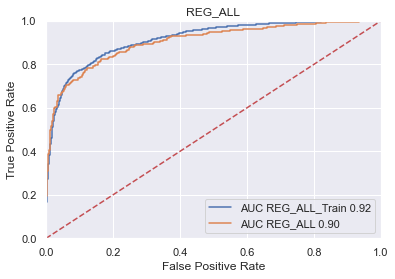

REG_ALL CLASSIFICATION ACCURACY
REG_ALL_Train  =  0.8949244966442953
REG_ALL  =  0.8951342281879194
-------




In [9]:
WHO = "REG_ALL"

CLM = LogisticRegression( solver = 'newton-cg', max_iter = 1000)
CLM = CLM.fit( X_train, Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train, Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test, Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] )
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

REG_ALL_CLM = TEST_CLM.copy()

### Log Regression Decision Tree

In [10]:
# Decision Tree
WHO = "TREE"

CLM = tree.DecisionTreeClassifier( max_depth = 4 , random_state = 1)
CLM = CLM.fit( X_train, Y_train[ TARGET_F ] )

feature_cols = list(X.columns.values)
vars_tree_flag = getTreeVars(CLM, feature_cols)

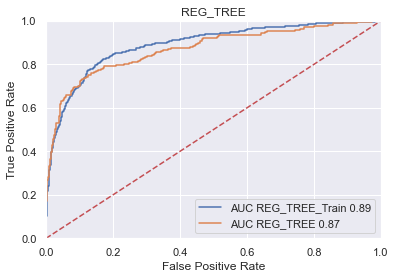

REG_TREE CLASSIFICATION ACCURACY
REG_TREE_Train  =  0.8779362416107382
REG_TREE  =  0.8842281879194631
-------



LOAN DEFAULT
---------
Total Variables:  11
INTERCEPT  =  -5.496504277642648
TRUNC_IMP_CLAGE  =  -0.006408870679868532
TRUNC_IMP_DEBTINC  =  0.1195958220830562
M_VALUE  =  3.8418726562961676
M_DEROG  =  -0.9030092603543634
M_YOJ  =  -0.40415570440221765
M_DEBTINC  =  2.7723504922337274
TRUNC_LOAN  =  -5.899533198995598e-06
TRUNC_IMP_MORTDUE  =  -1.8118375072700154e-06
O_IMP_DELINQ  =  1.4376676908434876
TRUNC_IMP_YOJ  =  -0.018202577883599847


In [11]:
# Decision Tree Logistic Regression Model
WHO = "REG_TREE"

CLM = LogisticRegression( solver='newton-cg', max_iter=1000)
CLM.fit( X_train[vars_tree_flag], Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train[vars_tree_flag], Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test[vars_tree_flag], Y_test[ TARGET_F ])

print_ROC_Curve( WHO, [TRAIN_CLM, TEST_CLM ] )
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

REG_TREE_CLM = TEST_CLM.copy()

REG_TREE_CLM_COEF = getCoefLogit(CLM, X_train[vars_tree_flag])


### Log Regression Random Forest

In [12]:
# Random Forest parameters and model
rf = RandomForestClassifier(n_jobs = - 1, random_state=1)
params = {
    'n_estimators': [5, 50, 100, 250],
    'max_depth': [2, 4, 8, 16, 32, None]
}

CLM = GridSearchCV(estimator = rf, param_grid = params, cv=5)
CLM.fit(X_train, Y_train[ TARGET_F ])

CLM = CLM.best_estimator_

feature_cols = list( X.columns.values )
vars_RF_flag = getEnsembleTreeVars( CLM, feature_cols)

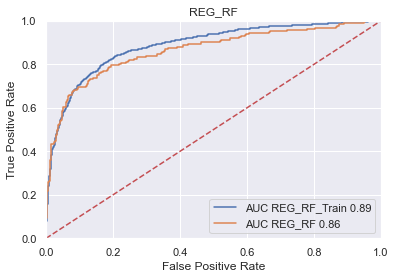

REG_RF CLASSIFICATION ACCURACY
REG_RF_Train  =  0.8743708053691275
REG_RF  =  0.8691275167785235
-------



LOAN DEFAULT
---------
Total Variables:  12
INTERCEPT  =  -5.3412233193786705
M_DEBTINC  =  2.761918949762073
TRUNC_IMP_DEBTINC  =  0.10994686241939265
TRUNC_IMP_CLAGE  =  -0.0058017132471112915
TRUNC_LOAN  =  -2.3788346922361393e-06
TRUNC_IMP_VALUE  =  -4.8951863241696515e-06
TRUNC_IMP_MORTDUE  =  5.212077933545603e-06
TRUNC_IMP_CLNO  =  -0.018746580418309677
TRUNC_IMP_YOJ  =  -0.008852986231003288
O_IMP_DELINQ  =  1.3413413390963045
TRUNC_IMP_NINQ  =  0.10789745641013053
O_IMP_DEROG  =  1.1063305596192978


In [13]:
# Random Forest Logistic Regression Model
WHO = "REG_RF"

RF_flag = []
for i in vars_RF_flag:
    theVar = i[0]
    RF_flag.append( theVar )

CLM = LogisticRegression( solver='newton-cg', max_iter=1000)
CLM.fit( X_train[RF_flag], Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train[RF_flag], Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test[RF_flag], Y_test[ TARGET_F ])

print_ROC_Curve( WHO, [TRAIN_CLM, TEST_CLM ] )
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

RF_CLM = TEST_CLM.copy()

REG_RF_CLM_COEF = getCoefLogit( CLM, X_train[RF_flag] )

### Log Regression Gradient Boosting

In [14]:
# Gradient Boosting parameters and model
gb = GradientBoostingClassifier(random_state=1)
params = {
    'n_estimators': [5,50,250,500],
    'max_depth': [1,3,5,7,9],
    'learning_rate': [0.01, 0.1, 1, 10, 100]
}

CLM = GridSearchCV(estimator = gb, param_grid = params, cv=5)
CLM.fit(X_train, Y_train[ TARGET_F ])

CLM = CLM.best_estimator_

feature_cols = list( X.columns.values )
vars_GB_flag = getEnsembleTreeVars( CLM, feature_cols)

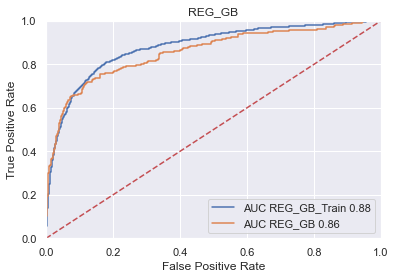

REG_GB CLASSIFICATION ACCURACY
REG_GB_Train  =  0.8712248322147651
REG_GB  =  0.8708053691275168
-------



LOAN DEFAULT
---------
Total Variables:  11
INTERCEPT  =  -5.165701180746141
M_DEBTINC  =  2.785464767757853
TRUNC_IMP_DEBTINC  =  0.10801921827460281
TRUNC_IMP_CLAGE  =  -0.005956789108412114
TRUNC_IMP_MORTDUE  =  4.460957563948973e-06
TRUNC_LOAN  =  -3.297684190284758e-07
TRUNC_IMP_VALUE  =  -4.72007979428013e-06
O_IMP_DELINQ  =  1.464925803265794
TRUNC_IMP_CLNO  =  -0.017304891778489057
TRUNC_IMP_YOJ  =  -0.011782692721964857
TRUNC_IMP_NINQ  =  0.1490717879902143


In [15]:
# Gradient Boosting Logistic Regression Model
WHO = "REG_GB"

GB_flag = []
for i in vars_GB_flag:
    theVar = i[0]
    GB_flag.append( theVar )

CLM = LogisticRegression( solver='newton-cg', max_iter=1000)
CLM.fit( X_train[GB_flag], Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train[GB_flag], Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test[GB_flag], Y_test[ TARGET_F ])

print_ROC_Curve( WHO, [TRAIN_CLM, TEST_CLM ] )
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

GB_CLM = TEST_CLM.copy()

REG_GB_CLM_COEF = getCoefLogit( CLM, X_train[GB_flag] )

### Log Regression Stepwise Selection

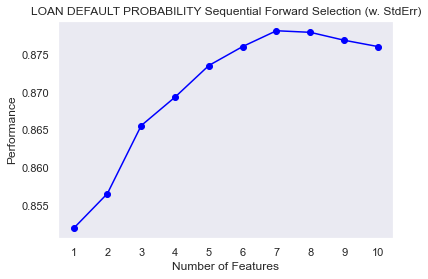

 ....... 
argmax
feature_names    (0, 1, 2, 3, 5, 7, 8)
avg_score                     0.878146
Name: 7, dtype: object
 ......... 


In [16]:
# use Decision Tree vars to use stepwise logistic regression 
U_train = X_train[ vars_tree_flag ]
stepVarNames = list( U_train.columns.values )
maxCols = U_train.shape[1]

# this model will be quite slow ; can be too long if many variables
sfs = SFS( LogisticRegression( solver='newton-cg', max_iter=100 ),      # logistic slower than linear here
         k_features=( 1, maxCols ),
         forward=True,
         floating=False,
         cv=3)
sfs.fit(U_train.values, Y_train[ TARGET_F ].values)

theFigure = plot_sfs(sfs.get_metric_dict(), kind=None)     # visualize selected feature subset performances
plt.title('LOAN DEFAULT PROBABILITY Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

dfm = pd.DataFrame.from_dict( sfs.get_metric_dict()).T
dfm = dfm[ ['feature_names', 'avg_score'] ]
dfm.avg_score = dfm.avg_score.astype(float)

print(" ....... ")
maxIndex = dfm.avg_score.argmax()
print("argmax")
print( dfm.iloc[ maxIndex, ] )
print(" ......... ")

In [17]:
# identify stepwise features and match to X_train column names 
stepVars = dfm.iloc[ maxIndex, ]
stepVars = stepVars.feature_names
print( stepVars )

finalStepVars = []
for i in stepVars :
    index = int(i)
    try:
        theName = stepVarNames[ index ]
        finalStepVars.append( theName )
    except :
        pass
    
for i in finalStepVars :
    print(i)
    
U_train = X_train[ finalStepVars ]
U_test = X_test[ finalStepVars ]

('0', '1', '2', '3', '5', '7', '8')
TRUNC_IMP_CLAGE
TRUNC_IMP_DEBTINC
M_VALUE
M_DEROG
M_DEBTINC
TRUNC_IMP_MORTDUE
O_IMP_DELINQ


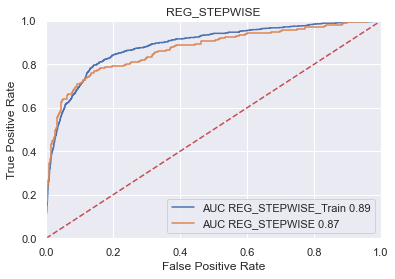

REG_STEPWISE CLASSIFICATION ACCURACY
REG_STEPWISE_Train  =  0.8779362416107382
REG_STEPWISE  =  0.8791946308724832
-------



LOAN DEFAULT
---------
Total Variables:  8
INTERCEPT  =  -5.701313708939491
TRUNC_IMP_CLAGE  =  -0.006861698071108672
TRUNC_IMP_DEBTINC  =  0.11922310556620057
M_VALUE  =  3.7590419247523887
M_DEROG  =  -0.938136547946134
M_DEBTINC  =  2.7809451974828416
TRUNC_IMP_MORTDUE  =  -1.6163107031889748e-06
O_IMP_DELINQ  =  1.4401782964104486


In [18]:
# Stepwise Logistic Regression Model
WHO = "REG_STEPWISE"

CLM = LogisticRegression( solver='newton-cg', max_iter=1000)
CLM.fit( U_train, Y_train[ TARGET_F ] ) 

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, U_train, Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, U_test, Y_test[ TARGET_F ])

print_ROC_Curve( WHO, [TRAIN_CLM, TEST_CLM ] )
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

REG_STEP_CLM = TEST_CLM.copy()

REG_STEP_CLM_COEF = getCoefLogit(CLM, U_train)

# Linear Regression  -  Expected Loss if Loan Defaults
### Lin Regression All Variables

In [19]:
# Linear Regression for all variables
WHO = "REG_ALL"

AMT = LinearRegression()
AMT = AMT.fit( W_train, Z_train[ TARGET_A ] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[ TARGET_A ] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[ TARGET_A ])
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

varNames = list( X_train.columns.values )

REG_ALL_AMT = TEST_AMT.copy() 

REG_ALL RMSE ACCURACY
REG_ALL_Train  =  4102.419911141471
REG_ALL  =  5126.255591010369
-------




### Lin Regression Decision Tree

In [20]:
# Decision Tree
AMT = tree.DecisionTreeRegressor( max_depth = 4 )
AMT = AMT.fit( W_train, Z_train[ TARGET_A ] )

feature_cols = list( X.columns.values )
vars_tree_amt = getTreeVars( AMT, feature_cols )

In [21]:
# Decision Tree Linear Regression Model
WHO = "REG_TREE"

AMT = LinearRegression()
AMT = AMT.fit( W_train[ vars_tree_amt], Z_train[ TARGET_A ] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train[ vars_tree_amt ], Z_train[ TARGET_A ])
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test[ vars_tree_amt ], Z_test[ TARGET_A ] )
print_Accuracy(WHO + "RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

varNames = list( X_train.columns.values )

REG_TREE_AMT = TEST_AMT.copy()

REG_TREE_AMT_COEF = getCoefLinear( AMT, X_train[vars_tree_amt])

REG_TREERMSE ACCURACY
REG_TREE_Train  =  4487.609532509109
REG_TREE  =  5549.9974700704415
-------



LOAN DEFAULT LOSSES
---------
Total Variables:  7
INTERCEPT  =  -15329.27360169499
TRUNC_IMP_CLAGE  =  -27.64151855938746
TRUNC_IMP_CLNO  =  310.197703413714
TRUNC_IMP_DEBTINC  =  238.51331009217762
M_DEBTINC  =  5852.103993964187
TRUNC_LOAN  =  0.8551017497630761
TRUNC_IMP_MORTDUE  =  -0.0005952937468768153


### Lin Regression Random Forest

In [22]:
# Random Forest parameters and model
rf = RandomForestRegressor(n_jobs = - 1, random_state=1)
params = {
    'n_estimators': [5, 50, 100, 250],
    'max_depth': [2, 4, 8, 16, 32, None]
}

AMT = GridSearchCV(estimator = rf, param_grid = params, cv=5)
AMT.fit(W_train, Z_train[ TARGET_A ])

AMT = AMT.best_estimator_

feature_cols = list( X.columns.values )
vars_RF_amt = getEnsembleTreeVars( AMT, feature_cols)

In [23]:
# Random Forest Linear Regression Model
WHO = "REG_RF"

RF_amt = []
for i in vars_RF_amt :
    theVar = i[0]
    RF_amt.append( theVar )


AMT = LinearRegression()
AMT = AMT.fit( W_train[RF_amt], Z_train[ TARGET_A ] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train[ RF_amt ], Z_train[ TARGET_A ])
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test[ RF_amt ], Z_test[ TARGET_A ] )
print_Accuracy(WHO + "RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

RF_AMT = TEST_AMT.copy()

REG_RF_AMT_COEF = getCoefLinear( AMT, X_train[RF_amt] )

REG_RFRMSE ACCURACY
REG_RF_Train  =  4487.6548826891585
REG_RF  =  5552.909665005261
-------



LOAN DEFAULT LOSSES
---------
Total Variables:  6
INTERCEPT  =  -15336.700904766552
TRUNC_LOAN  =  0.8543255659686454
TRUNC_IMP_CLNO  =  309.7041931058464
TRUNC_IMP_DEBTINC  =  238.26328557932516
TRUNC_IMP_CLAGE  =  -27.64150119657678
M_DEBTINC  =  5853.313048878967


### Lin Regression Gradient Boosting

In [24]:
# Gradient Boosting parameters and model
gb = GradientBoostingRegressor(random_state=1)
params = {
    'n_estimators': [5,50,250,500],
    'max_depth': [1,3,5,7,9],
    'learning_rate': [0.01, 0.1, 1, 10, 100]
}

AMT = GridSearchCV(estimator = gb, param_grid = params, cv=5)
AMT.fit(W_train, Z_train[ TARGET_A ])

AMT = AMT.best_estimator_

feature_cols = list( X.columns.values )
vars_GB_amt = getEnsembleTreeVars( AMT, feature_cols)

In [25]:
# Gradient Boosting Linear Regression Model
WHO = "REG_GB"

GB_amt = []
for i in vars_GB_amt:
    theVar = i[0]
    GB_amt.append( theVar )

AMT = LinearRegression()
AMT = AMT.fit( W_train[GB_amt], Z_train[ TARGET_A ] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train[GB_amt], Z_train[ TARGET_A ] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test[GB_amt], Z_test[ TARGET_A ])
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

GB_AMT = TEST_AMT.copy()

REG_GB_AMT_COEF = getCoefLinear( AMT, X_train[GB_amt] )

REG_GB RMSE ACCURACY
REG_GB_Train  =  4487.654882689158
REG_GB  =  5552.909665005261
-------



LOAN DEFAULT LOSSES
---------
Total Variables:  6
INTERCEPT  =  -15336.700904766523
TRUNC_LOAN  =  0.8543255659686454
TRUNC_IMP_CLNO  =  309.7041931058467
TRUNC_IMP_CLAGE  =  -27.64150119657686
M_DEBTINC  =  5853.313048878969
TRUNC_IMP_DEBTINC  =  238.26328557932453


### Lin Regression Stepwise Selection

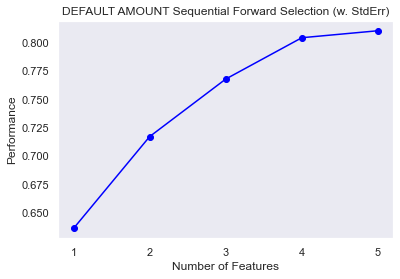

 ................... 
argmax
feature_names    (0, 1, 2, 3, 4)
avg_score               0.810663
Name: 5, dtype: object
 ................... 
('0', '1', '2', '3', '4')
TRUNC_LOAN
TRUNC_IMP_CLNO
TRUNC_IMP_CLAGE
M_DEBTINC
TRUNC_IMP_DEBTINC


In [26]:
# Stepwise Selection
V_train = W_train[ GB_amt ]
stepVarNames = list( V_train.columns.values )
maxCols = V_train.shape[1]

sfs = SFS( LinearRegression(),
         k_features=(1, maxCols ),
         forward = True,
         floating = False,
         scoring = 'r2',
         cv=5
         )
sfs.fit(V_train.values, Z_train[ TARGET_A ].values)

theFigure = plot_sfs(sfs.get_metric_dict(), kind=None)
plt.title('DEFAULT AMOUNT Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

dfm = pd.DataFrame.from_dict( sfs.get_metric_dict()).T
dfm = dfm[ ['feature_names', 'avg_score'] ]
dfm.avg_score = dfm.avg_score.astype(float)

print(" ................... ")
maxIndex = dfm.avg_score.argmax()
print("argmax")
print( dfm.iloc[ maxIndex, ] )
print(" ................... ")

stepVars = dfm.iloc[ maxIndex, ]
stepVars = stepVars.feature_names
print( stepVars )

finalStepVars = []
for i in stepVars :
    index = int(i)
    try :
        theName = stepVarNames[ index ]
        finalStepVars.append( theName )
    except :
        pass

for i in finalStepVars :
    print(i)

V_train = W_train[ finalStepVars ]
V_test = W_test[ finalStepVars ]

In [27]:
# Linear Regression Stepwise
WHO = "REG_STEPWISE"

AMT = LinearRegression()
AMT = AMT.fit( V_train, Z_train[ TARGET_A])

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, V_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, V_test, Z_test[TARGET_A])
print_Accuracy( WHO + " RMSE ACCURACY", [TRAIN_AMT, TEST_AMT])

REG_STEP_AMT = TEST_AMT.copy()

REG_STEP_AMT_COEF = getCoefLinear(AMT, V_train)

REG_STEPWISE RMSE ACCURACY
REG_STEPWISE_Train  =  4487.654882689158
REG_STEPWISE  =  5552.909665005261
-------



LOAN DEFAULT LOSSES
---------
Total Variables:  6
INTERCEPT  =  -15336.700904766523
TRUNC_LOAN  =  0.8543255659686454
TRUNC_IMP_CLNO  =  309.7041931058467
TRUNC_IMP_CLAGE  =  -27.64150119657686
M_DEBTINC  =  5853.313048878969
TRUNC_IMP_DEBTINC  =  238.26328557932453


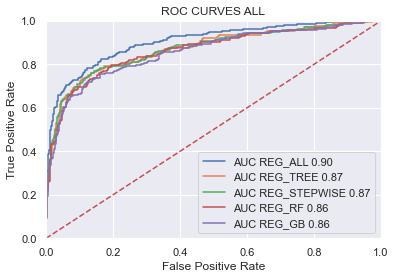

ALL CLASSIFICATION ACCURACY
REG_ALL  =  0.8951342281879194
REG_TREE  =  0.8842281879194631
REG_STEPWISE  =  0.8791946308724832
REG_GB  =  0.8708053691275168
REG_RF  =  0.8691275167785235
-------


ALL LOAN DEFAULT LOSSES MODEL ACCURACY
REG_ALL  =  5126.255591010369
REG_TREE  =  5549.9974700704415
REG_RF  =  5552.909665005261
REG_GB  =  5552.909665005261
REG_STEPWISE  =  5552.909665005261
-------




In [28]:
ALL_CLM = [ REG_ALL_CLM, REG_TREE_CLM, RF_CLM, GB_CLM, REG_STEP_CLM ]

ALL_CLM = sorted( ALL_CLM, key = lambda x: x[4], reverse=True )
print_ROC_Curve( "ROC CURVES ALL", ALL_CLM ) 

ALL_CLM = sorted( ALL_CLM, key = lambda x: x[1], reverse=True )
print_Accuracy( "ALL CLASSIFICATION ACCURACY", ALL_CLM )


ALL_AMT = [ REG_ALL_AMT, REG_TREE_AMT, RF_AMT, GB_AMT, REG_STEP_AMT ]
ALL_AMT = sorted( ALL_AMT, key = lambda x: x[1] )
print_Accuracy( "ALL LOAN DEFAULT LOSSES MODEL ACCURACY", ALL_AMT )

# Tensor Flow Model - Predict Loan Defaults

In [29]:
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
theScaler = MinMaxScaler()
theScaler.fit( X_train )

MinMaxScaler()

In [30]:
def get_TF_ProbAccuracyScores( NAME, MODEL, X, Y ) :
    probs = MODEL.predict( X )
    pred_list = []
    for p in probs :
        pred_list.append( np.argmax( p ) )
    pred = np.array( pred_list )
    acc_score = metrics.accuracy_score(Y, pred)
    p1 = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve( Y, p1)
    auc = metrics.auc(fpr,tpr)
    return [NAME, acc_score, fpr, tpr, auc]

In [44]:
WHO = "Tensor_FLow"

U_train = theScaler.transform( X_train )        # transforms data so all variables between 0 and 1
U_test = theScaler.transform( X_test )

U_train = pd.DataFrame( U_train )          # convert to dataframes
U_test = pd.DataFrame( U_test )

U_train.columns = list( X_train.columns.values )    # convert U dataframe with same column names as X
U_test.columns = list( X_train.columns.values )

U_train = U_train[ GB_flag ]                        # good to first remove some bad variables
U_test = U_test[ GB_flag ]

In [53]:
# F is for Flag Y/N default
F_theShapeSize = U_train.shape[1]                             
F_theActivation = tf.keras.activations.relu           # activation function
F_theLossMetric = tf.keras.losses.SparseCategoricalCrossentropy()      # loss metric
F_theOptimizer = tf.keras.optimizers.Adam()                        # optimizer
F_theEpochs = 800                                          # number of times going through data

F_theUnits = int( 2*F_theShapeSize /3)                    #  how many hidden nodes should I have in my layer? Start 2x number and scale back

#F_theUnits = int(7)

F_LAYER_01 = tf.keras.layers.Dense( units=F_theUnits, activation=F_theActivation, input_dim=F_theShapeSize )   # create layer
F_LAYER_DROP = tf.keras.layers.Dropout( 0.2 )          # drop and 2nd layer (deep learning neural network ; have 2 at most)
F_LAYER_02 = tf.keras.layers.Dense( units=F_theUnits, activation=F_theActivation )
F_LAYER_OUTPUT = tf.keras.layers.Dense( units=2, activation=tf.keras.activations.softmax )

### Test Activation Functions

***
I tested the activation functions by running the model at 100 epochs, with two hidden layers, and otherwise only changing the activation functions. I choose to go forward with the relu activation function, as it performed the best for both accuracy and area under the curve. If I did not choose the relu function, I would use the next best performing function tanh.

Relu: AUC TRAIN = 0.9, AUC TEST = 0.88 ; Accuracy Train = 0.8786, Accuracy Test = 0.8792

Softmax: AUC TRAIN = 0.89, AUC TEST = 0.86 ; Accuracy Train = 0.8677, Accuracy Test = 0.8674

Softplus: AUC TRAIN = 0.88, AUC TEST = 0.86 ; Accuracy Train = 0.8695, Accuracy Test = 0.8649

Tanh: AUC TRAIN = 0.9, AUC TEST = 0.87 ; Accuracy Train = 0.88, Accuracy Test = 0.8725
***

### Test One vs Two Hidden Layers

***
I tested one vs. two hidden layers by running the model at 100 epochs with the relu activation function. The two hidden layers performed slightly better for accuracy, and about the same for area under the curve.
***

### Dropout Layer

***
The dropout layer slightly improves both the accuracy and area under the curve for the model.
***

### Variable Selection Technique

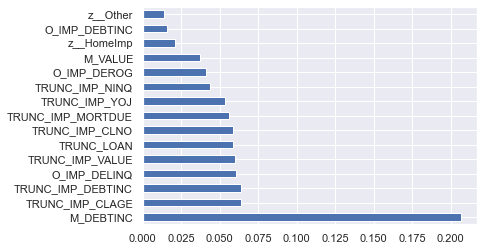

M_DEBTINC            0.207074
TRUNC_IMP_CLAGE      0.063635
TRUNC_IMP_DEBTINC    0.063622
O_IMP_DELINQ         0.060924
TRUNC_IMP_VALUE      0.059709
TRUNC_LOAN           0.058887
TRUNC_IMP_CLNO       0.058714
TRUNC_IMP_MORTDUE    0.056183
TRUNC_IMP_YOJ        0.053750
TRUNC_IMP_NINQ       0.043637
dtype: float64
None
['M_DEBTINC', 'TRUNC_IMP_DEBTINC', 'TRUNC_IMP_CLAGE', 'TRUNC_IMP_MORTDUE', 'TRUNC_LOAN', 'TRUNC_IMP_VALUE', 'O_IMP_DELINQ', 'TRUNC_IMP_CLNO', 'TRUNC_IMP_YOJ']


In [33]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X_train, Y_train[TARGET_F])
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()
#print(model.feature_importances_)
print(feat_importances.nlargest(10))
print(feat_importances.nlargest(10).name)

GB_flag_wo_tin = GB_flag[:-1]
print(GB_flag_wo_tin)

***
This variable selection technique provided essentially the same output as the GB_flag output. I tested the model with the top 9 variables featured above. The accuracy was not as high, but the area under the curve performed similarly.
***

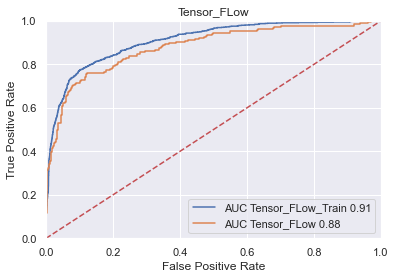

Tensor_FLow CLASSIFICATION ACCURACY
Tensor_FLow_Train  =  0.8859060402684564
Tensor_FLow  =  0.863255033557047
-------




In [54]:
CLM = tf.keras.Sequential()
CLM.add( F_LAYER_01 )
CLM.add( F_LAYER_DROP )
CLM.add( F_LAYER_02 )
CLM.add( F_LAYER_OUTPUT )
CLM.compile( loss=F_theLossMetric, optimizer=F_theOptimizer)
CLM.fit( U_train, Y_train[TARGET_F], epochs=F_theEpochs, verbose=False )

TRAIN_CLM = get_TF_ProbAccuracyScores( WHO + "_Train", CLM, U_train, Y_train[ TARGET_F ] )
TEST_CLM = get_TF_ProbAccuracyScores( WHO, CLM, U_test, Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

# Tensor Flow Model - Predict Loan Loss

In [55]:
V_train = theScaler.transform( W_train )
V_test = theScaler.transform( W_test )

V_train = pd.DataFrame( V_train )
V_test = pd.DataFrame( V_test )

V_train.columns = list( W_train.columns.values )
V_test.columns = list( W_train.columns.values )

V_train = V_train[ GB_amt ]
V_test = V_test[ GB_amt ]

In [59]:
A_theShapeSize = V_train.shape[1]
A_theActivation = tf.keras.activations.softplus
A_theLossMetric = tf.keras.losses.MeanSquaredError()
A_theOptimizer = tf.keras.optimizers.Adam()
A_theEpochs = 800

A_theUnits = int( 2*A_theShapeSize  )

A_LAYER_01 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation, input_dim=A_theShapeSize )
A_LAYER_DROP = tf.keras.layers.Dropout( 0.2 )
A_LAYER_02 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation )
A_LAYER_OUTPUT = tf.keras.layers.Dense( units=1, activation=tf.keras.activations.linear )

In [60]:
AMT = tf.keras.Sequential()
AMT.add( A_LAYER_01 )
AMT.add( A_LAYER_DROP )
AMT.add( A_LAYER_02 )
AMT.add( A_LAYER_OUTPUT )
AMT.compile( loss=A_theLossMetric, optimizer=A_theOptimizer)
AMT.fit( V_train, Z_train[TARGET_A], epochs=A_theEpochs, verbose=False )

### Test Activation Functions

***
I tested the activation functions by running the model and only changing the activation functions. I choose to go forward with the softplus activation function, as it had the best RMSE accuracy. If I did not choose the softplus function, I would use the next best performing function relu.

Relu: RMSE Accuracy Train = 4692.52  , RMSE Accuracy Test = 5721.30

Softmax: RMSE Accuracy Train = 17099.34  , RMSE Accuracy Test = 17602.01 

Softplus: RMSE Accuracy Train =  4318.62 , RMSE Accuracy Test = 5306.15

Tanh: RMSE Accuracy Train = 16929.69  , RMSE Accuracy Test = 17437.67
***

### Test One vs. Two Hidden Layers

*** 
I tested one vs. two hidden layers by running the model at 100 epochs with the relu activation function. The two hidden layers had a higher RMSE accuracy.
***

### Dropout Layer

***
The dropout layer did not perform better than without in regards to the RMSE accuracy
***

### Variable Selection Technique

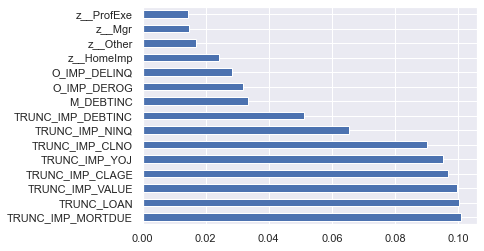

TRUNC_IMP_MORTDUE    0.101110
TRUNC_LOAN           0.100455
TRUNC_IMP_VALUE      0.099667
TRUNC_IMP_CLAGE      0.097004
TRUNC_IMP_YOJ        0.095372
TRUNC_IMP_CLNO       0.090188
TRUNC_IMP_NINQ       0.065310
TRUNC_IMP_DEBTINC    0.051042
M_DEBTINC            0.033370
O_IMP_DEROG          0.031779
dtype: float64
None
['TRUNC_LOAN', 'TRUNC_IMP_CLNO', 'TRUNC_IMP_CLAGE', 'M_DEBTINC', 'TRUNC_IMP_DEBTINC']
Index(['z__HomeImp', 'z__MISSING', 'z__Mgr', 'z__Office', 'z__Other',
       'z__ProfExe', 'z__Sales', 'z__Self', 'M_MORTDUE', 'M_VALUE', 'M_DEROG',
       'M_DELINQ', 'M_NINQ', 'M_YOJ', 'M_CLAGE', 'M_CLNO', 'M_DEBTINC',
       'O_LOAN', 'TRUNC_LOAN', 'O_IMP_MORTDUE', 'TRUNC_IMP_MORTDUE',
       'O_IMP_VALUE', 'TRUNC_IMP_VALUE', 'O_IMP_DEROG', 'TRUNC_IMP_DEROG',
       'O_IMP_DELINQ', 'TRUNC_IMP_DELINQ', 'O_IMP_NINQ', 'TRUNC_IMP_NINQ',
       'O_IMP_YOJ', 'TRUNC_IMP_YOJ', 'O_IMP_CLAGE', 'TRUNC_IMP_CLAGE',
       'O_IMP_CLNO', 'TRUNC_IMP_CLNO', 'O_IMP_DEBTINC', 'TRUNC_IMP_DEBTINC'],
     

In [50]:
model = ExtraTreesClassifier()
model.fit(W_train, Z_train[TARGET_A])
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()
#print(model.feature_importances_)
print(feat_importances.nlargest(10))
print(feat_importances.nlargest(10).name)

# GB_flag_wo_tin = GB_flag[:-1]
print(GB_amt)
print(X_train.columns)

In [51]:
var_sel_amt = ['TRUNC_IMP_MORTDUE', 'TRUNC_IMP_CLAGE', 'TRUNC_IMP_VALUE', 'TRUNC_IMP_YOJ', 'TRUNC_IMP_CLNO']

***
This variable selection technique performed essentially the same on the RMSE accuracy.
***

In [61]:
TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, V_train[GB_amt], Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, V_test[GB_amt], Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

TF_CLM = TEST_CLM.copy()
TF_AMT = TEST_AMT.copy()

Tensor_FLow RMSE ACCURACY
Tensor_FLow_Train  =  4309.227952977862
Tensor_FLow  =  5293.1160723056055
-------




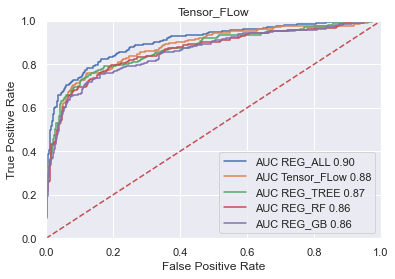

ALL CLASSIFICATION ACCURACY
REG_ALL  =  0.8951342281879194
REG_TREE  =  0.8842281879194631
REG_GB  =  0.8708053691275168
REG_RF  =  0.8691275167785235
Tensor_FLow  =  0.863255033557047
-------


ALL DEFAULT AMOUNT MODEL ACCURACY
REG_ALL  =  5126.255591010369
Tensor_FLow  =  5293.1160723056055
REG_TREE  =  5549.9974700704415
REG_RF  =  5552.909665005261
REG_GB  =  5552.909665005261
-------




In [62]:
ALL_CLM = [ REG_ALL_CLM, REG_TREE_CLM, RF_CLM, GB_CLM, TF_CLM ]

ALL_CLM = sorted( ALL_CLM, key = lambda x: x[4], reverse=True )
print_ROC_Curve( WHO, ALL_CLM ) 

ALL_CLM = sorted( ALL_CLM, key = lambda x: x[1], reverse=True )
print_Accuracy( "ALL CLASSIFICATION ACCURACY", ALL_CLM )



ALL_AMT = [ REG_ALL_AMT, REG_TREE_AMT, RF_AMT, GB_AMT, TF_AMT ]
ALL_AMT = sorted( ALL_AMT, key = lambda x: x[1] )
print_Accuracy( "ALL DEFAULT AMOUNT MODEL ACCURACY", ALL_AMT )

*** 
For the loan default predictions, I would likely use the decision tree regression model. It uses fewer variables than the regression using all variables, and performs similar to or better than the other models. 

I would likely use the decision tree regression model for the loss amount prediction as well. The tensor flow and all variable regression models perform better, but it does not seem like it is that much better to justify using a more complex model. The decision tree is a simpler story to tell and performs closely enough to go forward with this model in both scenarios.
***